## Initial imports

In [1]:
from scm.plams import *
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from typing import List

IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 250, 250

## Helper class and function

The ``MoleculeConnector`` class and ``substitute()`` method below are convenient to use.

In [2]:
class MoleculeConnector:
    def __init__(self, molecule, connector, name='molecule'):
        self.name = name
        self.molecule = molecule
        self.molecule.properties.name = name
        self.connector = connector # 2-tuple of integers, unlike the Molecule.substitute() method which uses two atoms

    def __str__(self):
        return  f'''
Name: {self.name}
{self.molecule}
Connector: {self.connector}. This means that when substitution is performed atom {self.connector[0]} will be kept in the substituted molecule. Atom {self.connector[1]}, and anything connected to it, will NOT be kept.
        '''
            

def substitute(substrate:MoleculeConnector, ligand:MoleculeConnector):
    """
        Returns: Molecule with the ligand added to the substrate, replacing the respective connector bonds.
    """
    molecule = substrate.molecule.copy()
    molecule.substitute(
        connector=(molecule[substrate.connector[0]], molecule[substrate.connector[1]]),
        ligand=ligand.molecule,
        ligand_connector=(ligand.molecule[ligand.connector[0]], ligand.molecule[ligand.connector[1]])
    )
    return molecule

def set_atom_indices(rdmol:Chem.rdchem.Mol, start=0):
    for atom in rdmol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx()+start) # give 1-based index
    return rdmol

def to_lewis(molecule:Molecule, template=None, regenerate:bool=True):
    if isinstance(molecule, Chem.rdchem.Mol):
        rdmol = molecule
    else:
        rdmol = to_rdmol(molecule)
    if regenerate:
        rdmol = Chem.RemoveHs(rdmol)
        smiles = Chem.MolToSmiles(rdmol)
        rdmol = Chem.MolFromSmiles(smiles)
    if template is not None:
        AllChem.GenerateDepictionMatching2DStructure(rdmol, template)
    try:
        if molecule.properties.name:
            rdmol.SetProp("_Name", molecule.properties.name)
    except AttributeError:
        pass
    return rdmol
        
def smiles2template(smiles:str):
    template = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(template)
    return template

def draw_lewis_grid(
    molecules:List[Molecule], 
    molsPerRow:int=4, 
    template_smiles:str=None, 
    regenerate:bool=False, 
    draw_atom_indices:bool=False,
    draw_legend:bool=True,
):
    template = None
    if template_smiles:
        template = smiles2template(template_smiles)
        
    rdmols = [to_lewis(x, template=template, regenerate=regenerate) for x in molecules]
    if draw_atom_indices:
        for rdmol in rdmols:
            set_atom_indices(rdmol, start=1)
    legends = None
    if draw_legend:
        try:
            legends = [x.properties.name or f"mol{i}" for i, x in enumerate(molecules)]
        except AttributeError:
            pass

    return Draw.MolsToGridImage(rdmols, molsPerRow=molsPerRow, legends=legends)

## Generate substrate molecule

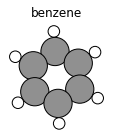

In [3]:
substrate_smiles = 'c1ccccc1'
substrate = from_smiles(substrate_smiles, forcefield='uff')
substrate.properties.name = "benzene"

plot_molecule(substrate)
plt.title(substrate.properties.name);

## Find out which bond to cleave

In the molecule you need to define which bond to cleave. To find out, run for example

In [4]:
substrate.write('substrate.xyz')

Then open ``substrate.xyz`` in the AMS GUI and find that atoms 6 (C) and 12 (H) are bonded. We will choose this bond to cleave.

Alternatively, we can plot the molecule inside a Jupyter notebook with RDkit to also find that atoms 6 (C) and 12 (H) are bonded.

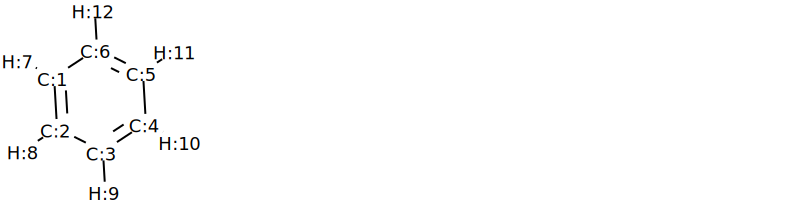

In [5]:
draw_lewis_grid([substrate], draw_atom_indices=True, draw_legend=False)

In [6]:
substrate_connector = MoleculeConnector(substrate, (6, 12), 'phenyl') # benzene becomes phenyl when bond between atoms 6,12 is cleaved

## Define ligands

Similarly for the ligand, if you do not know which bond to cleave, write the molecule to a .xyz file and find out.

Or plot it with rdkit in the Jupyter notebook.

**Note**: The ligands below have an extra hydrogen  or even more atoms compared to the name that they're given.

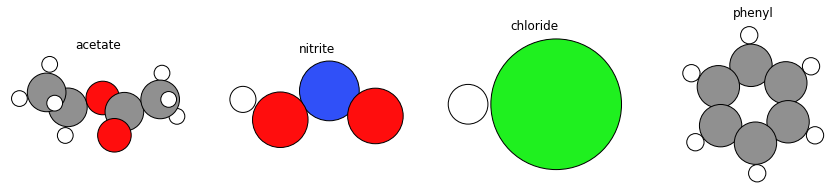

In [7]:
ligands = [
    MoleculeConnector(from_smiles('CCOC(=O)C', forcefield='uff'), (3, 2), 'acetate'), # ethyl acetate, bond from O to C cleaved
    MoleculeConnector(from_smiles('O=NO', forcefield='uff'), (3, 4), 'nitrite'), # nitrous acid, bond from O to H cleaved
    MoleculeConnector(from_smiles('Cl', forcefield='uff'), (1, 2), 'chloride'), # hydrogen chloride, bond from Cl to H cleaved
    MoleculeConnector(from_smiles('c1ccccc1', forcefield='uff'), (6,12), 'phenyl')  # benzene, bond to C to H cleaved
]

ligand_molecules = [ligand.molecule for ligand in ligands]

fig, axes = plt.subplots(1, len(ligands), figsize=(15,3))

for ax, ligand in zip(axes, ligands):
    plot_molecule(ligand.molecule, ax=ax)
    ax.set_title(ligand.name)

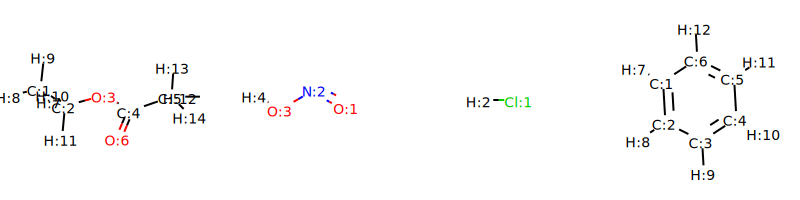

In [8]:
draw_lewis_grid(ligand_molecules, draw_atom_indices=True, draw_legend=False, molsPerRow=4)

Above we see that cleaving the bonds from O(3)-C(2), O(3)-H(4), Cl(1)-H(2), and C(6)-H(12) will give the acetate, nitrite, chloride, and phenyl substituents, respectively.

## Generate substituted molecules

In [9]:
mols = []

for ligand in ligands:
    mol = substitute(substrate_connector, ligand)
    mol.properties.name = f'{substrate_connector.name}--{ligand.name}'
    mols.append(mol)
    print(f'Writing {mol.properties.name}.xyz')
    mol.write(f'{mol.properties.name}.xyz')
    print(f'{mol.properties.name} formula: {mol.get_formula(as_dict=True)}')

Writing phenyl--acetate.xyz
phenyl--acetate formula: {'C': 8, 'H': 8, 'O': 2}
Writing phenyl--nitrite.xyz
phenyl--nitrite formula: {'C': 6, 'H': 5, 'O': 2, 'N': 1}
Writing phenyl--chloride.xyz
phenyl--chloride formula: {'C': 6, 'H': 5, 'Cl': 1}
Writing phenyl--phenyl.xyz
phenyl--phenyl formula: {'C': 12, 'H': 10}


## Plot 3D structures with PLAMS / ASE

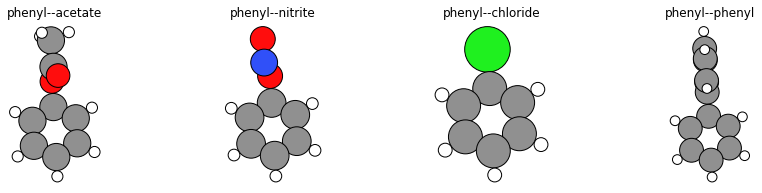

In [10]:
fig, axes = plt.subplots(1, len(mols), figsize=(15,3))

for ax, mol in zip(axes, mols):
    plot_molecule(mol, ax=ax)
    ax.set_title(mol.properties.name)

## Plot 2D Lewis structures with RDKit

The molecules can be aligned by using a benzene template. The ``regenerate`` option regenerates the molecule with RDkit to clean up the atomic positions.

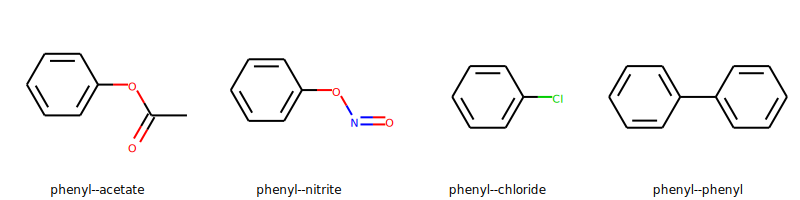

In [11]:
draw_lewis_grid(mols, template_smiles=substrate_smiles, regenerate=True)